# figures for report

this notebook generates the figures described in the report outline.
run from the repo root so relative paths resolve.


In [1]:
from pathlib import Path
import sys
import glob
import json
import yaml
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt

root = Path.cwd()
sys.path.insert(0, str(root))

import matplotlib as mpl
mpl.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 11,
    'axes.labelsize': 10,
    'legend.fontsize': 9,
    'figure.dpi': 200,
    'savefig.dpi': 300,
    'axes.grid': False,
    'lines.linewidth': 1.5,
})


## 1) log-mel vs pcen
produces `fig_features.pdf`.


wrote fig_features.pdf


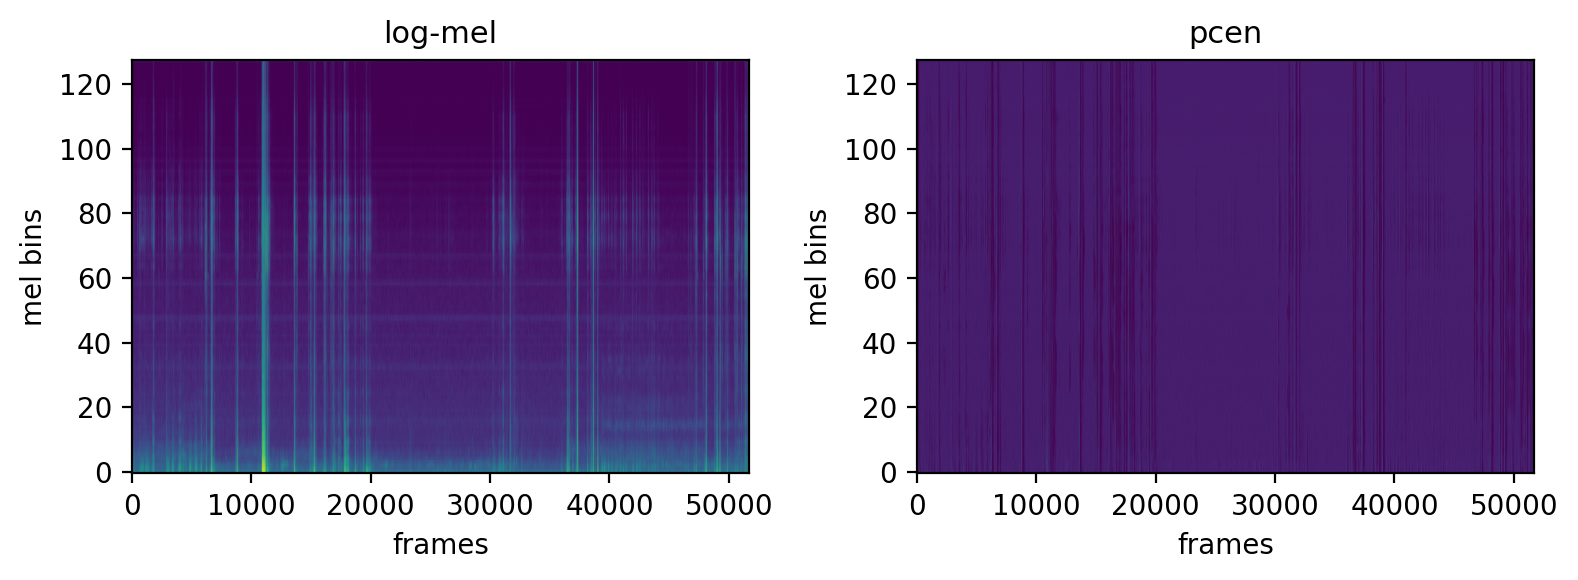

In [8]:
from fsbio.features import FeatureExtractor

cfg = yaml.safe_load(open(root / 'config.yaml'))
conf = type('C', (), {})()
conf.features = type('F', (), cfg['features'])()

wav = root / 'data/raw/development/Development_Set/Training_Set/JD/sp4f1_2015_04_24-05_00_00_0002.wav'
if not wav.exists():
    print('missing example wav:', wav)
else:
    y, _ = librosa.load(wav, sr=conf.features.sr)
    mel = librosa.feature.melspectrogram(
        y=y,
        sr=conf.features.sr,
        n_fft=conf.features.n_fft,
        hop_length=conf.features.hop_mel,
        n_mels=conf.features.n_mels,
        fmax=conf.features.fmax,
    )
    logmel = librosa.power_to_db(mel, ref=np.max)
    pcen = FeatureExtractor(conf).extract_feature(y)

    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.imshow(logmel, origin='lower', aspect='auto')
    plt.title('log-mel')
    plt.xlabel('frames')
    plt.ylabel('mel bins')

    plt.subplot(1,2,2)
    plt.imshow(pcen, origin='lower', aspect='auto')
    plt.title('pcen')
    plt.xlabel('frames')
    plt.ylabel('mel bins')

    plt.tight_layout()
    plt.savefig('fig_features.pdf', bbox_inches='tight')
    print('wrote fig_features.pdf')


## 2) event duration histogram + patch length
produces `fig_event_durations.pdf`.


wrote fig_event_durations.pdf


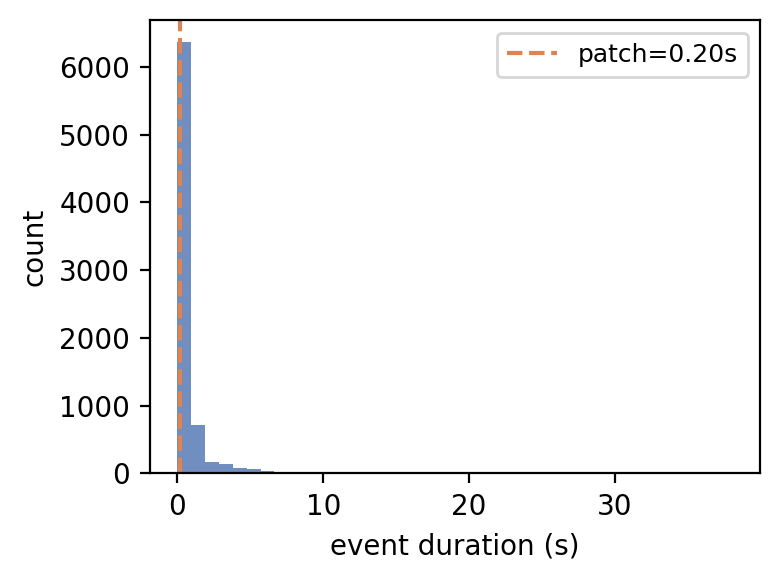

In [3]:
cfg = yaml.safe_load(open(root / 'config.yaml'))
seg_len = float(cfg['features']['seg_len'])

csvs = glob.glob(str(root / 'data/raw/development/Development_Set/Training_Set/**/*.csv'), recursive=True)
dur = []
for p in csvs:
    df = pd.read_csv(p)
    if 'Starttime' not in df.columns:
        continue
    pos = df[df.apply(lambda r: (r == 'POS').any(), axis=1)]
    if not pos.empty:
        dur.extend((pos['Endtime'] - pos['Starttime']).values.tolist())

if not dur:
    print('no durations found')
else:
    plt.figure(figsize=(4,3))
    plt.hist(dur, bins=40, color='#4C72B0', alpha=0.8)
    plt.axvline(seg_len, color='#DD8452', linestyle='--', label=f'patch={seg_len:.2f}s')
    plt.xlabel('event duration (s)')
    plt.ylabel('count')
    plt.legend()
    plt.tight_layout()
    plt.savefig('fig_event_durations.pdf', bbox_inches='tight')
    print('wrote fig_event_durations.pdf')


## 3) threshold sweep vs f-measure
expects results in folders like `score_t0.45`.
produces `fig_threshold_sweep.pdf`.


In [4]:
rows = []
for p in glob.glob(str(root / 'score_t*/Evaluation_report_TESTteam_VAL_*.json')):
    try:
        t = float(p.split('score_t')[-1].split('/')[0])
    except ValueError:
        continue
    data = json.load(open(p))
    f = data['overall_scores']['fmeasure (percentage)']
    rows.append((t, f))

rows = sorted(rows)
if not rows:
    print('no score_t* reports found')
else:
    ts = [r[0] for r in rows]
    fs = [r[1] for r in rows]
    plt.figure(figsize=(4,3))
    plt.plot(ts, fs, marker='o')
    plt.xlabel('threshold')
    plt.ylabel('f-measure (%)')
    plt.tight_layout()
    plt.savefig('fig_threshold_sweep.pdf', bbox_inches='tight')
    print('wrote fig_threshold_sweep.pdf')


no score_t* reports found


## 4) detection timeline (gt vs predictions)
produces `fig_timeline.pdf`.


In [ ]:
pred_path = root / 'eval_output.csv'
gt_path = root / 'data/raw/development/Development_Set/Validation_Set/PB/BUK1_20181011_001004.csv'

if not pred_path.exists() or not gt_path.exists():
    print('missing eval_output.csv or ground truth file')
else:
    preds = pd.read_csv(pred_path)
    gt = pd.read_csv(gt_path)

    file_name = 'BUK1_20181011_001004.wav'
    p = preds[preds['Audiofilename'] == file_name]
    g = gt[gt['Q'] == 'POS'].copy()

    plt.figure(figsize=(7,2))
    g = g.iloc[5:]
    for i, r in g.iterrows():
        label = 'gt' if i == g.index[0] else ''
        plt.hlines(1, r['Starttime'], r['Endtime'], color='#4C72B0', linewidth=6, label=label)

    for i, r in p.iterrows():
        label = 'pred' if i == p.index[0] else ''
        plt.hlines(0.6, r['Starttime'], r['Endtime'], color='#DD8452', linewidth=6, label=label)

    plt.yticks([])
    plt.xlabel('time (s)')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig('fig_timeline.pdf', bbox_inches='tight')
    print('wrote fig_timeline.pdf')
